<a href="https://colab.research.google.com/github/kimbaorrr/us_economic_news/blob/main/us_economic_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import *
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
import nltk
from nltk.corpus import stopwords
import os
import re
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from gensim.models import Word2Vec
import pickle

In [ ]:
# Chọn thư mục hoạt động

%cd /content/drive/MyDrive/AI/NLP

/content/drive/MyDrive/AI/NLP


In [ ]:
# Nạp API key Kaggle

!rm -rf /root/.kaggle
!mkdir -p /root/.kaggle
!cp ../api_keys/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Tạo các thư mục liên quan

!mkdir -p datasets/us_economic/
!mkdir -p imgs/us_economic/
!mkdir -p models/us_economic/
!mkdir -p logs/us_economic/

In [ ]:
# Thiết lập chung

ds_path = 'datasets/us_economic/'
img_path = 'imgs/us_economic/'
model_path = 'models/us_economic/'
log_path = 'logs/us_economic/'

In [ ]:
# Tải tập dữ liệu từ Kaggle

import kaggle as kg

kg.api.dataset_download_files(
    'heeraldedhia/us-economic-news-articles',
    ds_path,
    unzip=True,
    quiet=False
)

Dataset URL: https://www.kaggle.com/datasets/heeraldedhia/us-economic-news-articles


100%|██████████| 4.61M/4.61M [00:00<00:00, 48.8MB/s]

In [ ]:
# Liệt kê các tệp có trong ds_path

!ls {ds_path}

US-Economic-News.csv


In [ ]:
# Nạp dữ liệu vào bộ nhớ

df = pd.read_csv(os.path.join(ds_path, 'US-Economic-News.csv'), encoding='latin1', delimiter=',')
df

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.6400,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.0000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.0000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.6750,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.6400,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,830985632,False,finalized,3,11/17/15 18:16,7.0,0.3511,yes,0.6641,wapo_152454634,2/11/52,"Sawyer Sees Strong Economy For 2 Years, Truce ...",NaN,NaN,Secretary of Commerce Charles W. Sawyer said y...
7996,830985633,False,finalized,3,11/18/15 8:10,NaN,NaN,no,1.0000,wapo_410349039,12/13/09,Oil's losses are airlines' gains,NaN,NaN,"U.S. stocks inched up last week, overcoming co..."
7997,830985634,False,finalized,3,11/18/15 12:12,NaN,NaN,no,1.0000,wapo_410346237,12/18/09,Full Senate to vote on Bernanke; PANEL ADVANCE...,NaN,NaN,Ben S. Bernanke cleared a key hurdle Thursday ...
7998,830985635,False,finalized,3,11/18/15 7:17,NaN,0.0000,no,0.6855,wapo_307808606,1/10/95,Reinventing Opportunities,NaN,NaN,The White House's push to contract out many fe...


In [ ]:
# Liệt kê các tên các cột

df.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'positivity', 'positivity:confidence', 'relevance',
       'relevance:confidence', 'articleid', 'date', 'headline',
       'positivity_gold', 'relevance_gold', 'text'],
      dtype='object')

In [ ]:
# Bỏ qua các thuộc tính thừa

df = df[['relevance', 'text']]
df

,relevance,text
0,yes,NEW YORK -- Yields on most certificates of dep...
1,no,The Wall Street Journal Online</br></br>The Mo...
2,no,WASHINGTON -- In an effort to achieve banking ...
3,no,The statistics on the enormous costs of employ...
4,yes,NEW YORK -- Indecision marked the dollar's ton...
...,...,...
7995,yes,Secretary of Commerce Charles W. Sawyer said y...
7996,no,"U.S. stocks inched up last week, overcoming co..."
7997,no,Ben S. Bernanke cleared a key hurdle Thursday ...
7998,no,The White House's push to contract out many fe...


#### Tiền xử lý cột Label

In [ ]:
# Đổi tên column cho dễ nhận biết

df = df.rename(columns={'relevance': 'label'})
df

,label,text
0,yes,NEW YORK -- Yields on most certificates of dep...
1,no,The Wall Street Journal Online</br></br>The Mo...
2,no,WASHINGTON -- In an effort to achieve banking ...
3,no,The statistics on the enormous costs of employ...
4,yes,NEW YORK -- Indecision marked the dollar's ton...
...,...,...
7995,yes,Secretary of Commerce Charles W. Sawyer said y...
7996,no,"U.S. stocks inched up last week, overcoming co..."
7997,no,Ben S. Bernanke cleared a key hurdle Thursday ...
7998,no,The White House's push to contract out many fe...


In [ ]:
# Liệt kê giá trị duy nhất của label ?

df['label'].unique()

array(['yes', 'no', 'not sure'], dtype=object)

In [ ]:
# Mapping label sang kiểu số nguyên để phân lớp

df['label'] = df['label'].map({'yes': 1, 'no': 0, 'not sure': 2})
df

,label,text
0,1,NEW YORK -- Yields on most certificates of dep...
1,0,The Wall Street Journal Online</br></br>The Mo...
2,0,WASHINGTON -- In an effort to achieve banking ...
3,0,The statistics on the enormous costs of employ...
4,1,NEW YORK -- Indecision marked the dollar's ton...
...,...,...
7995,1,Secretary of Commerce Charles W. Sawyer said y...
7996,0,"U.S. stocks inched up last week, overcoming co..."
7997,0,Ben S. Bernanke cleared a key hurdle Thursday ...
7998,0,The White House's push to contract out many fe...


In [ ]:
# Kiểm tra giá trị N/A

df.isna().sum()

label    0
text     0
dtype: int64

label
0    6571
1    1420
2       9
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

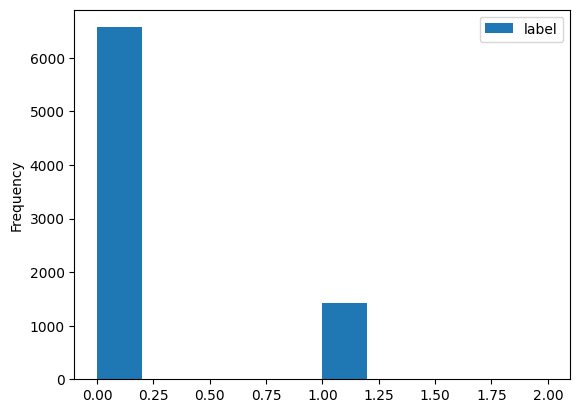

In [ ]:
# Kiểm tra mức độ cân bằng của nhãn

print(df['label'].value_counts())
df.plot.hist(column='label')

In [ ]:
# Loại bỏ label=2 do quá ít

df = df[df['label'] != 2]
print(df[df['label'] == 2])

Empty DataFrame
Columns: [label, text]
Index: []


In [ ]:
# Tạo nhãn từ cột label

classes = ['no', 'yes']

label
0    6571
1    1420
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

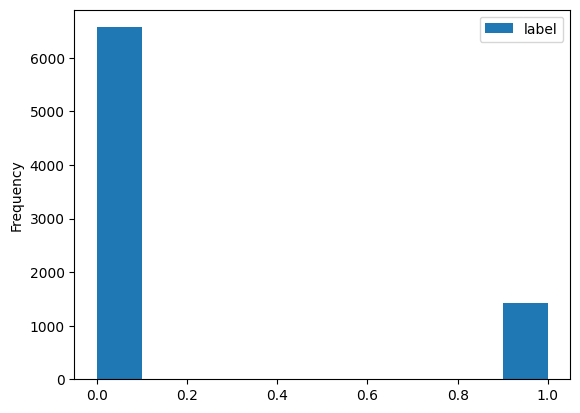

In [ ]:
# Kiểm tra độ cân bằng nhãn

print(df['label'].value_counts())
df.plot.hist(column='label')

In [ ]:
# Tái cân bằng nhãn
x = df['text'].values.reshape(-1, 1)
y = df['label']

label_resampler = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = label_resampler.fit_resample(x, y)

label
0    1420
1    1420
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

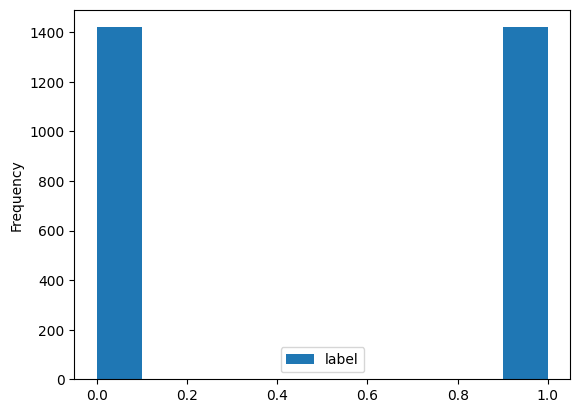

In [ ]:
# Tạo DataFrame mới từ dữ liệu đã được under-sampling
df = pd.DataFrame({'text': X_resampled.flatten(), 'label': y_resampled})

# Kiểm tra lại mức độ cân bằng
print(df['label'].value_counts())
df.plot.hist(column='label')

#### Tiền xử lý cột Text

In [ ]:
# Thiết lập danh mục stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)

{'a', 'who', 'while', 'our', "you'll", 'of', 'or', 'their', 'be', 'how', 'to', 'here', 'some', 'above', 'y', 'nor', 'because', 'should', 'm', 'whom', 'do', "she's", 'couldn', "you'd", 'ain', 'more', 'other', 'too', 'my', 'these', 'his', 'through', 'is', "aren't", 'after', 'it', 'does', 'at', 'don', "hadn't", 'before', 'can', "needn't", 'was', 'under', 'herself', "you're", 'against', "you've", 'ma', "it's", "shan't", 'me', 'both', 'yourself', "couldn't", 'mightn', 'further', 'won', 'then', 'as', 's', 'shan', 'again', 'this', 'than', 'you', 'yourselves', 'i', 'where', 'needn', 'ourselves', 'are', 'by', 'now', 'what', 'out', 'them', 'itself', 'any', 'being', 'all', 'they', "that'll", 'he', 'when', 'so', 'been', 'once', 'hers', 'each', "haven't", 'such', "mustn't", 'during', "wasn't", "isn't", 'and', "weren't", 'for', 'if', 'aren', 'll', 'haven', 'himself', 'but', "should've", 'theirs', 'd', 'him', 'have', 'doing', 'am', 'has', 'about', 'most', "don't", 'hasn', 'will', 'an', 'myself', 'you

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Thiết lập từ điển để chuẩn hóa ngữ nghĩa các từ

nltk.download('wordnet')
word_net = set(wordnet.words())
word_net

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


{'borassus',
 'trawl_line',
 'prattler',
 'vitamin_b1',
 'carnegie',
 'fortuity',
 'haber',
 'ill-treated',
 'old_world_chat',
 'stroheim',
 'bermudian',
 'dracunculus_medinensis',
 'family_salviniaceae',
 'pulicaria_dysenterica',
 'polyurethane_foam',
 'universalist',
 'insensitiveness',
 'sudra',
 'sea_squab',
 'capital_of_suriname',
 'obtuse_triangle',
 'rip_up',
 'displeased',
 'collegiate',
 'coalpit',
 'fagus_sylvatica_pendula',
 'quetzalcoatl',
 'hired',
 'butternut_squash',
 'woodrow_wilson',
 'natality',
 'achromatise',
 'analogous',
 'genus_argiope',
 'aridity',
 'misappropriation',
 'asparagus_pea',
 'traditionalist',
 'cucurbita_moschata',
 'granger',
 'by_the_day',
 'footgear',
 'strike-slip_fault',
 'resew',
 'adventure_story',
 'crispy',
 'sightsee',
 'pageboy',
 'benniseed',
 'south_american_poison_toad',
 'rumex_obtusifolius',
 'dalmatian_iris',
 'nureyev',
 'awash',
 'posturer',
 'chiliast',
 'cordate_leaf',
 'criminal_record',
 'oxalis_crenata',
 "lady's_thistle",
 '

In [ ]:
df['text'].sample(3)

1037    A sharply divided U.S. Court of Appeals panel ...
1878    HARTFORD, Conn. -- United Technologies Corp.'s...
457     The FX Global Call covers the main news events...
Name: text, dtype: object

In [ ]:
# Tiền xử lý chuỗi

def text_preprocessing(text):
  # Chuyển chữ thường
  text = text.lower()
  # Loại bỏ html tag
  text = re.sub(r'<.*?>', '', text).strip()
  # Thay thế kí tự đặc biệt bằng khoảng trắng
  text = re.sub(r'[^\w\s]', ' ', text).strip()
  # Loại bỏ số & các kí tự đặc biệt
  text = re.sub(r'[^a-zA-Z\s]', '', text).strip()
  text = re.sub(r'\b[a-zA-Z]\b\s*', '', text).strip()
  # Loại bỏ các từ dừng stopwords
  text = ' '.join([word for word in text.split() if word not in stop_words])
  # Loại bỏ các khoảng trắng thừa đầu & cuối cây
  text = text.strip()
  # Chuẩn hóa ngữ nghĩa các từ dựa trên từ điển
  text = WordNetLemmatizer().lemmatize(text)
  return text


In [ ]:
# Bắt đầu chuẩn hóa

df['text'] = df['text'].apply(text_preprocessing)

In [ ]:
for i in range(25):
  print(df['text'][i], '\n')

upi president kennedy said message afl cio executive council today emerged recession secretary labor arthur goldberg arrived white house helicopter union summer resort deliver mr kennedy letter afl cio president george meany mr kennedy said man economic problems continue confront us demand best efforts find solution thanked labor leaders support administration foreign policy major domestic programs past meany immediately pledged afl cio would continue back president international matters help keep america free goldberg former top adviser afl cio leadership began private talks meany shortly arriving new york 

latest news economy good terms low unemployment rebounding growth falling inflation declining interest rates record stock prices private analysts government policymakers alike cheering yesterday labor department added good news reporting august producer prices finished goods fell percent three similarly good months federal reserve officials said report indicates last winter inflat

In [ ]:
# Chuyển văn bản thành vector Word2Vec

# Tách các cụm từ
sentences = [text.split() for text in df['text']]

# Xây dựng mô hình
vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Fit mô hình để chuyển văn bản thành vector
def text_to_vector(text):
  words = text.split()
  vectors = [vec_model.wv[word] for word in words if word in vec_model.wv]
  if vectors:
    return np.mean(vectors, axis=0)
  else:
    return np.zeros(vec_model.vector_size)

x = np.array([text_to_vector(text) for text in df['text']])
y = df['label'].values


In [ ]:
print(x.shape, y.shape)

(2840, 100) (2840,)


#### Đào tạo mô hình & dự đoán

In [ ]:
# Tách tập dữ liệu Train/Test

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=.25,
    random_state=42,
    stratify=y
)

print('Train:', x_train.shape[0])
print('Test:', x_test.shape[0])

Train: 2130
Test: 710


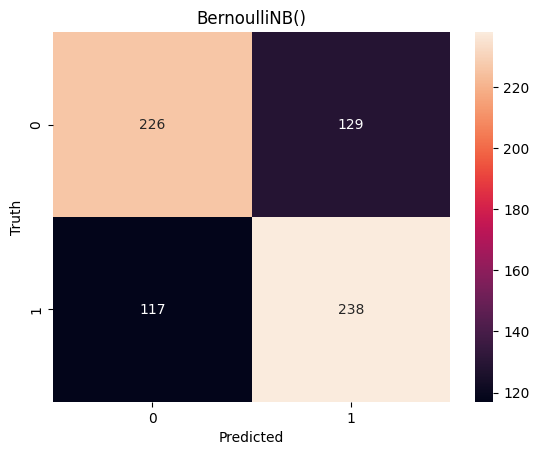

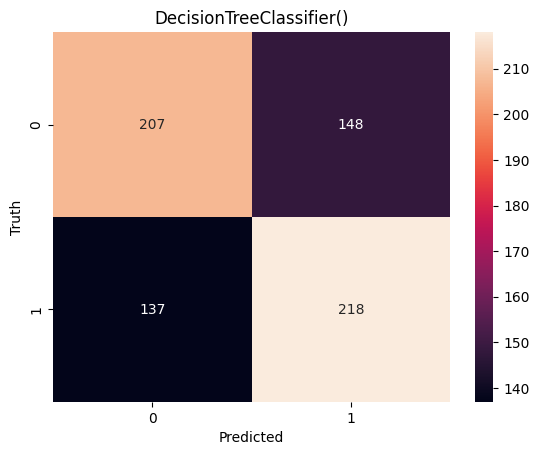

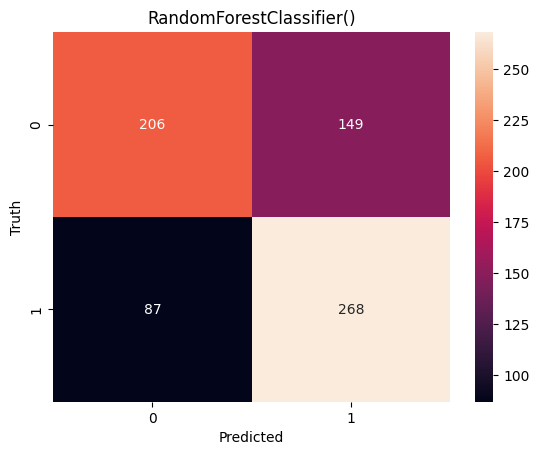

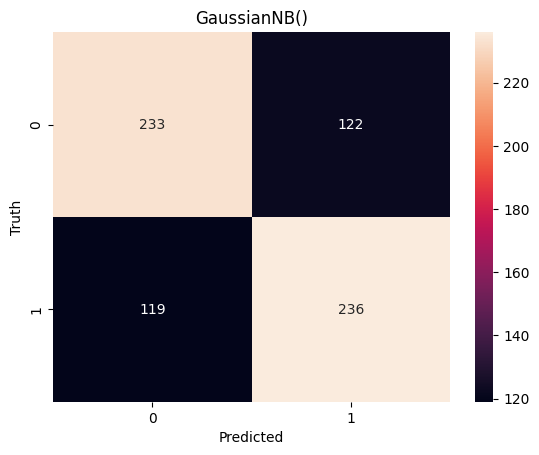

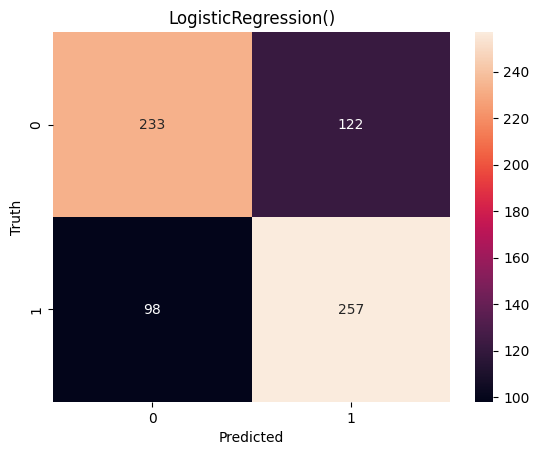

BernoulliNB(): 0.6535211267605634
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       355
           1       0.68      0.72      0.70       355

    accuracy                           0.69       710
   macro avg       0.69      0.69      0.69       710
weighted avg       0.69      0.69      0.69       710

DecisionTreeClassifier(): 0.5985915492957746
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       355
           1       0.68      0.72      0.70       355

    accuracy                           0.69       710
   macro avg       0.69      0.69      0.69       710
weighted avg       0.69      0.69      0.69       710

RandomForestClassifier(): 0.6676056338028169
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       355
           1       0.68      0.72      0.70       355

    accuracy                           0.69       710
   m

In [ ]:
# Đào tạo & chọn ra mô hình tốt nhất
selected_model = None
accuracy = {}
accuracy.clear()
for i_model in [BernoulliNB(), DecisionTreeClassifier(), RandomForestClassifier(), GaussianNB(), LogisticRegression()]:
  model = i_model
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  accuracy[model] = accuracy_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)
  plt.title(model)
  sns.heatmap(cm, annot=True, fmt='d')
  plt.xlabel('Predicted')
  plt.ylabel('Truth')
  plt.show()

for model, score in accuracy.items():
  print(f'{model}: {score}')
  print(classification_report(y_test, y_pred))

selected_model = max(accuracy, key=accuracy.get)
print('=> Best model:', selected_model, accuracy[selected_model])

In [ ]:
# Dự đoán dữ liệu mới

input_texts = [
    "Wall street were collapsed !!!",
    "My name is James. @</hr?>",
    "Breaking news",
    "Phone number is +555-2039-2094",
    "America is the world's largest national economy and leading global trader",
    "Trading Economics provides data for 20 million economic indicators from 196 countries including actual values, consensus figures, forecasts, historical time",
    "Today, wind sear is)strong !",
    "I'm playing football",
    'Real gross domestic product (GDP) increased at an annual rate of 1.4 percent in the first quarter of 2024, according to the "third" estimate. In the fourth quarter of 2023, real GDP increased 3.4 percent. The increase in the first quarter primarily reflected increases in consumer spending, housing investment, business investment, and state and local government that were partly offset by a decrease in inventory investment. Imports, which are a subtraction in the calculation of GDP, increased',
    "The U.S. current-account deficit widened by $15.9 billion, or 7.2 percent, to $237.6 billion in the first quarter of 2024, according to statistics released today by the U.S. Bureau of Economic Analysis. The revised fourth-quarter deficit was $221.8 billion. The first-quarter deficit was 3.4 percent of current-dollar gross domestic product, up from 3.2 percent in the fourth quarter."
    ]

for pred_text in input_texts:
  pred_text_preprocessed = text_preprocessing(pred_text)
  pred_text_vector = text_to_vector(pred_text_preprocessed).reshape(1, -1)
  pred_result = selected_model.predict(pred_text_vector)

  print('Input:',pred_text)
  print('Preprocessed input:', pred_text_preprocessed)
  print('Output:',classes[pred_result[0]])
  print('\n')

Input: Wall street were collapsed !!!
Preprocessed input: wall street collapsed
Output: yes


Input: My name is James. @</hr?>
Preprocessed input: name james
Output: no


Input: Breaking news
Preprocessed input: breaking news
Output: yes


Input: Phone number is +555-2039-2094
Preprocessed input: phone number
Output: no


Input: America is the world's largest national economy and leading global trader
Preprocessed input: america world largest national economy leading global trader
Output: yes


Input: Trading Economics provides data for 20 million economic indicators from 196 countries including actual values, consensus figures, forecasts, historical time
Preprocessed input: trading economics provides data million economic indicators countries including actual values consensus figures forecasts historical time
Output: yes


Input: Today, wind sear is)strong !
Preprocessed input: today wind sear strong
Output: yes


Input: I'm playing football
Preprocessed input: playing football
Output

In [ ]:
# Xuất mô hình

with open(os.path.join(model_path, 'us_economic_model.pkl'), 'wb') as f:
    pickle.dump(selected_model, f)